## **Introduction**
Ce notebook présente la mise en œuvre d'un modèle de classification d'images en utilisant le réseau de neurones **EfficientNetB1**.  
Les réseaux de neurones convolutifs (**CNN**) sont devenus la norme pour les tâches de vision par ordinateur  
grâce à leur capacité à extraire automatiquement des caractéristiques complexes des images.  
L'utilisation de modèles **pré-entraînés** comme EfficientNetB1 permet de tirer parti de l'apprentissage par transfert,  
où un modèle formé sur une grande quantité de données peut être adapté à une nouvelle tâche avec un minimum de réentraînement. 
#### Réseaux de Neurones Convolutifs et EfficientNetB1
EfficientNetB1 est une variante de CNN qui équilibre efficacement la taille du modèle et les performances en ajustant uniformément les dimensions de profondeur, largeur et résolution d'entrée.  
Dans ce notebook, nous utilisons EfficientNetB1 pour effectuer une classification d'images avec une taille d'entrée fixée à 400x400 pixels.
#### Apprentissage par Transfert
L'apprentissage par transfert (**transfert learning**) est une technique qui consiste à réutiliser un modèle pré-entraîné sur une nouvelle tâche.  
Cela est particulièrement utile lorsque les données d'entraînement disponibles sont limitées.  
Dans ce cas, nous utilisons EfficientNetB1, pré-entraîné sur ImageNet, et nous adaptons ses couches supérieures à notre ensemble de données spécifique.  
Les couches inférieures, qui capturent des caractéristiques générales, sont **"gelées"** pour éviter le réapprentissage, tandis que les couches supérieures sont ajustées aux nouvelles données.
#### Gestion des Données Déséquilibrées
Lors de la formation de modèles de classification, il est courant de rencontrer des ensembles de données déséquilibrés, où certaines classes sont sous-représentées. Pour gérer cela, nous employons des techniques d'*oversampling* et d'*undersampling* :

**Oversampling** : Augmente artificiellement le nombre d'exemples dans les classes minoritaires pour les équilibrer avec les classes majoritaires.  
**Undersampling** : Réduit le nombre d'exemples dans les classes majoritaires pour les équilibrer avec les classes minoritaires.  
Ces techniques permettent d'améliorer la capacité du modèle à généraliser et à reconnaître efficacement toutes les classes.  
## Structure du Notebook

1. **Préparation des Données** : Chargement et prétraitement des données, y compris la gestion des données déséquilibrées.
   
2. **Construction du Modèle** : Initialisation et personnalisation d'EfficientNetB1 pour notre tâche spécifique.

3. **Entraînement et Évaluation** : Entraînement du modèle sur l'ensemble de données d'entraînement et évaluation des performances à l'aide de mesures telles que la précision et la matrice de confusion.


#### Importation des bibliothèques
Si une carte graphique est présente, la configuration GPU est effectuée pour s'assurer que le modèle  
utilise efficacement les ressources matérielles disponibles.  


In [1]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
maintenant = datetime.now()
print(maintenant)
import tensorflow as tf
from keras.optimizers import SGD,Adam

# activation GPU

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)




from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense # Pour construire un réseau de neurones et
                                                 # instancier une couche d'entrée et une couche den
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
import matplotlib.pyplot as plt
import os
#import cv2
import gc
import itertools # Pour créer des itérateurs
import pickle

2024-06-24 20:54:48.596575
1 Physical GPUs, 1 Logical GPUs


#### Définition des paramètres du 
1. Les **hyperparamètre** du modèle sont définis ici, notamment la taille des images d'entrée, le nombre d'époques d'entraînement, la taille du batch, et les stratégies de sur-échantillonnage et de sous-échantillonnage.
2. **FREEZE_LAYERS** indique le nombre de couches gelées dans le modèle pré-entrainé EfficientNetB1, afin de ne pas réapprendre ces couches pendant l'entraînement.

In [2]:
VERSION = "_FINAL"
SUFFIXE_FICHIER = "EfficientNetB1" + VERSION
STRATEGIE = "sampling_strategy_B1" + VERSION +".csv" # effectifs par classe retenu après over et under sampling
IMGSIZE       = 400    # Taille de l'image en input
EPOCH         = 20     # nombre d'epoch 
BATCH_SIZE    = 32     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 340    # pour un EfficientNetB1 freeze de réapprentissage de certaines couches (340 couches au total)
NB_PAR_LABEL_MAX = 5000 # nombre maximun d'enregistrement par label = undersampling
NB_PAR_LABEL_MIN = 2000 # nombre maximun d'enregistrement par label = oversampling
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

#### Importation de modules personnalisés

In [3]:
import sys
sys.path.append('../src')
import Bibli_DataScience_3_2 as ds
import CNN_DataScience_2 as cnn

section :  ['DOSSIER', 'FICHIER']


In [5]:
# Pour recharger si nesséssaire
import imp
imp.reload(ds)
imp.reload(cnn)

#### Chargement des données
1. Cette cellule charge les données d'entraînement à partir de fichiers CSV, crée un DataFrame en effectuant une jointure entre les caractéristiques (df_feats) et les étiquettes cibles (df_target).
2. Un dictionnaire de catégories (catdict) est créé pour mapper les codes de produit à leurs définitions, ce qui est utile pour l'interprétation des résultats du modèle.

In [4]:
# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)
#cat=df_target['prdtypecode'].sort_values().unique()
nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
Lcat=df_target.sort_values(by = ['prdtypecode'])['prdtypecode'].unique()
Lcat

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905], dtype=int64)

In [5]:
df['nom_image']=df.apply(lambda row: "image_" +  str(row['imageid']) 
                                     + "_product_" + str(row['productid']) + ".jpg",axis=1)
print("Nb enreg ", str(df.shape[0]))
df_img=df.copy()

Nb enreg  84916


In [6]:
folder_path = ds.get_RACINE_IMAGES() 
df['filepath']=df['nom_image'].apply(lambda x : os.path.join(folder_path, x))


#### test de lecture d'image¶

Taille de l'image : (500, 500, 3)


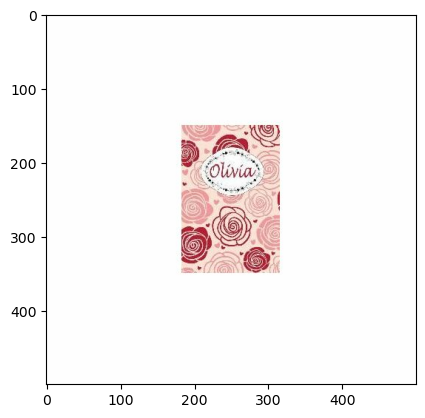

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Chemin de l'image
filename = df.nom_image[0]
filepath = os.path.join(folder_path, filename)
# Lecture du fichier
im = tf.io.read_file(filepath)

# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)

print("Taille de l'image :", im.shape)

# Affichage du tensor
plt.imshow(im);

#### Redimensionnement de l'image
Pour avoir un temps d'entrainement du modèle raisonnable,  
il est nécessaire de redimensionner les images.  
**A l'origine les images ont une taille de 500*500 pixels.**

In [8]:
filepath = df.filepath[0]
# Lecture du fichier
im = tf.io.read_file(filepath)
# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)
# Redimensionnement
tf.image.resize(im, size=(IMGSIZE,IMGSIZE))


<tf.Tensor: shape=(400, 400, 3), dtype=float32, numpy=
array([[[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       ...,

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 25

#### Séparation des données en ensembles d'entraînement et de test
Commentaire :
1. La cellule utilise **train_test_split** de sklearn pour diviser les données en ensembles d'entraînement (80%) et de test (20%).
2. **stratify***=y garantit que la division préserve la distribution des classes dans les ensembles.
3. **random_state**=1234 assure la reproductibilité de la division.

In [9]:
from sklearn.model_selection import train_test_split

import numpy as np

X = df.drop('prdtypecode', axis=1)
y = df['prdtypecode'] 

X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(X, y, train_size=0.8, random_state=1234,
                                                              stratify=y,shuffle=True)

#### Conversion des ensembles de données en tableaux NumPy

In [10]:
X_train = np.array(X_train_avant['filepath'])
print(X_train.shape)
X_test = np.array(X_test_avant['filepath'])
y_train = np.array(y_train_avant)
print(X_test.shape)
y_test = np.array(y_test_avant )
X_train=X_train.reshape(-1,1)
y_train=y_train.reshape(-1,1)
X_test=X_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

(67932,)
(16984,)


#### Identification des classes majoritaires

In [11]:
y_serie =pd.Series(y_train.reshape(-1,)).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

2583


2583    8167
1560    4058
1300    4036
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
2585    1997
1302    1993
1281    1656
50      1345
2462    1137
2905     698
60       666
2220     659
1301     646
1940     642
1180     611
Name: count, dtype: int64

#### Stratégie d'échantillonnage - Sous-échantillonnage  (*unsersampling*)
Commentaire :
1. Définit une stratégie d'échantillonnage où le nombre maximal d'échantillons pour chaque classe est limité à **NB_PAR_LABEL_MAX** (ici 5000).
2. Crée un dictionnaire **sampling_strategy** qui spécifie le nombre d'échantillons à conserver pour chaque classe.
3. La stratégie est sauvegardée dans un fichier CSV.

In [12]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] > NB_PAR_LABEL_MAX:  
    sampling_strategy[key] = NB_PAR_LABEL_MAX
del y_serie,new_class_counts
#print(type(sampling_strategy))
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)
print("Stategie de sampling")
sampling_strategy

Stategie de sampling


{2583: 5000,
 1560: 4058,
 1300: 4036,
 2060: 3994,
 2522: 3991,
 1280: 3896,
 2403: 3819,
 2280: 3808,
 1920: 3442,
 1160: 3162,
 1320: 2593,
 10: 2493,
 2705: 2209,
 1140: 2137,
 2582: 2071,
 40: 2006,
 2585: 1997,
 1302: 1993,
 1281: 1656,
 50: 1345,
 2462: 1137,
 2905: 698,
 60: 666,
 2220: 659,
 1301: 646,
 1940: 642,
 1180: 611}

#### Application du sous-échantillonnage
Utilise **RandomUnderSampler** pour appliquer la stratégie de sous-échantillonnage, réduisant ainsi le nombre d'échantillons des classes majoritaires.

In [13]:

rUs = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_ru, y_ru = rUs.fit_resample(X_train, y_train  )
#del   X_Reshape, y
#gc.collect()
print(len(X_ru))
print(len(X_ru))

64765
64765


#### Comptage des classes après sous-échantillonnage

**la classe la plus représentée** du jeu d'entrainement comporte maintemant **5000 occurences**

In [14]:
y_serie =pd.Series(y_ru).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

2583


2583    5000
1560    4058
1300    4036
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
2585    1997
1302    1993
1281    1656
50      1345
2462    1137
2905     698
60       666
2220     659
1301     646
1940     642
1180     611
Name: count, dtype: int64

#### Stratégie d'échantillonnage - Sur-échantillonnage
On effectue un **oversampling** définit par le paramètre : **NB_PAR_LABEL_MIN** (cf debut de programme,  2000)   
On utilisera par la suite un génarateur d'images pour générer des images différentes de chaque enregistrement   

In [15]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] <NB_PAR_LABEL_MIN :
  #if key in [1180,2220]:  
    sampling_strategy[key] = NB_PAR_LABEL_MIN
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)  
print("Stategie de sampling")
sampling_strategy

Stategie de sampling


{2583: 5000,
 1560: 4058,
 1300: 4036,
 2060: 3994,
 2522: 3991,
 1280: 3896,
 2403: 3819,
 2280: 3808,
 1920: 3442,
 1160: 3162,
 1320: 2593,
 10: 2493,
 2705: 2209,
 1140: 2137,
 2582: 2071,
 40: 2006,
 2585: 2000,
 1302: 2000,
 1281: 2000,
 50: 2000,
 2462: 2000,
 2905: 2000,
 60: 2000,
 2220: 2000,
 1301: 2000,
 1940: 2000,
 1180: 2000}

#### Application du sur-échantillonnage
Commentaire :

1. Utilise RandomOverSampler pour appliquer la stratégie de sur-échantillonnage, augmentant le nombre d'échantillons des classes minoritaires.
2. shuffle mélange les données après sur-échantillonnage pour éviter tout biais dû à l'ordre des échantillons.

In [16]:
from imblearn.over_sampling import RandomOverSampler
rOs = RandomOverSampler(sampling_strategy=sampling_strategy)
#rOs = RandomOverSampler(sampling_strategy=sampling_strategy,random_state=1234,shrinkage=1)
X_train_path, y_train = rOs.fit_resample(X_ru, y_ru)
X_train_path, y_train = shuffle(X_train_path, y_train, random_state=42)

#### Vérification de la distribution après sur-échantillonnage

In [17]:
y_res_series = pd.Series(y_train).value_counts()
print(y_res_series)


2583    5000
1560    4058
1300    4036
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
1302    2000
50      2000
2585    2000
1301    2000
2905    2000
1180    2000
2462    2000
1281    2000
60      2000
2220    2000
1940    2000
Name: count, dtype: int64


#### Aplatir les étiquettes de test
Utilise **ravel** pour transformer l'étiquette de test en un tableau unidimensionnel, simplifiant ainsi les manipulations futures.

In [18]:
y_test=y_test.ravel()

#### Redimensionnement des chemins d'entraînement et de test
Les chemins d'accès aux images d'entraînement et de test sont convertis en tableaux unidimensionnels pour faciliter l'utilisation dans les étapes suivantes du traitement.

In [19]:

X_train_path=X_train_path.reshape(-1,)
print(X_train_path.shape)
X_test_path=X_test
X_test_path=X_test_path.reshape(-1,)
print(X_test_path.shape)

(74715,)
(16984,)


#### Sauvegarde des chemins de fichiers

In [20]:


with open(ds.get_RACINE_SAUVEGARDE() + 'X_train_path.pkl', 'wb') as f:
    pickle.dump(X_train_path, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'X_test_path.pkl', 'wb') as f:
    pickle.dump(X_test_path, f)

#### Encodage et transformation des étiquettes
Commentaire :

1. Utilise LabelEncoder pour transformer les étiquettes en valeurs numériques.
2. Convertit les étiquettes en format catégoriel (one-hot encoding) pour les préparer à l'entrée dans le réseau de neurones.

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)
print("*********************")
print(y_train_Network)
print(y_test_Network)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

(74715, 27)
(16984, 27)
*********************
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
### augmentation des données
random_flip_left_right -> Retournez aléatoirement une image horizontalement (de gauche à droite)
random_flip_up_down -> Retournez aléatoirement une image verticalement (du haut vers  le bas)
random_brightness -> Ajuster la luminosité par un facteur aléatoire
random_contrast -> Ajuster le contraste par un facteur aléatoire
image.rot90 -> Rotation de 90 degrés

#### Chargement des images
1. Fonction *augment_image*
   La fonction augment_image est utilisée pour appliquer des transformations aléatoires aux images,  
    une technique courante appelée augmentation des données. 
    Cela aide le modèle à généraliser mieux en exposant le réseau à des variations différentes des images d'entrée.  
3. Fonction *load_and_augment_image*  
    Cette fonction lit une image à partir d'un chemin de fichier, la décode et l'augmente en utilisant *augment_image*.  
4. Fonction *load_image*  
    Cette fonction est similaire à *load_and_augment_image*, mais elle ne fait qu'un redimensionnement sans augmentation.  
#### Création des Datasets
Commentaires :

1. Les datasets dataset_train et dataset_test sont créés à partir des chemins d'images et des étiquettes correspondantes  
    en utilisant tf.data.Dataset.from_tensor_slices.
2. *dataset_train.map(...)* utilise *load_and_augment_image* pour charger et augmenter les images d'entraînement  
    de manière parallèle (num_parallel_calls=-1 pour utiliser tous les threads disponibles), puis regroupe  
    les données par batch de taille **BATCH_SIZE**.
3. *dataset_test.map(...)* utilise *load_image* pour charger les images de test sans augmentation, les regroupant également par **BATCH_SIZE**.  
Ce ***pipeline*** de données est optimisé pour la performance et l'efficacité lors de l'entraînement du modèle.
Ces étapes préparent efficacement les données pour le modèle, assurant que les images sont augmentées de manière aléatoire  
pendant l'entraînement, ce qui contribue à améliorer la robustesse du modèle, tout en conservant les images de test inchangées
pour une évaluation précise.
    
  


In [22]:

@tf.function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    #image = tf.image.rot90(image, k=1) 
    image = tf.image.random_crop(image,[400, 400, 3])
    return image



@tf.function
def load_and_augment_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = augment_image(image)
    return tf.image.resize(image, resize)

@tf.function
def load_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels=3)
    return tf.image.resize(im, resize)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_Network ))

dataset_train = dataset_train.map(lambda x, y : [load_and_augment_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)
#dataset_train = dataset_train.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_Network))

dataset_test = dataset_test.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)

#dataset_train_aug = tf.data.Dataset.from_tensor_slices((X_train_path_aug, y_train_Network_aug))
#dataset_train_aug = dataset_train_aug.map(lambda x, y: [load_and_augment_image2(x), y], num_parallel_calls=-1).batch(32)



####  Contrôle des Images Originales et Augmentées

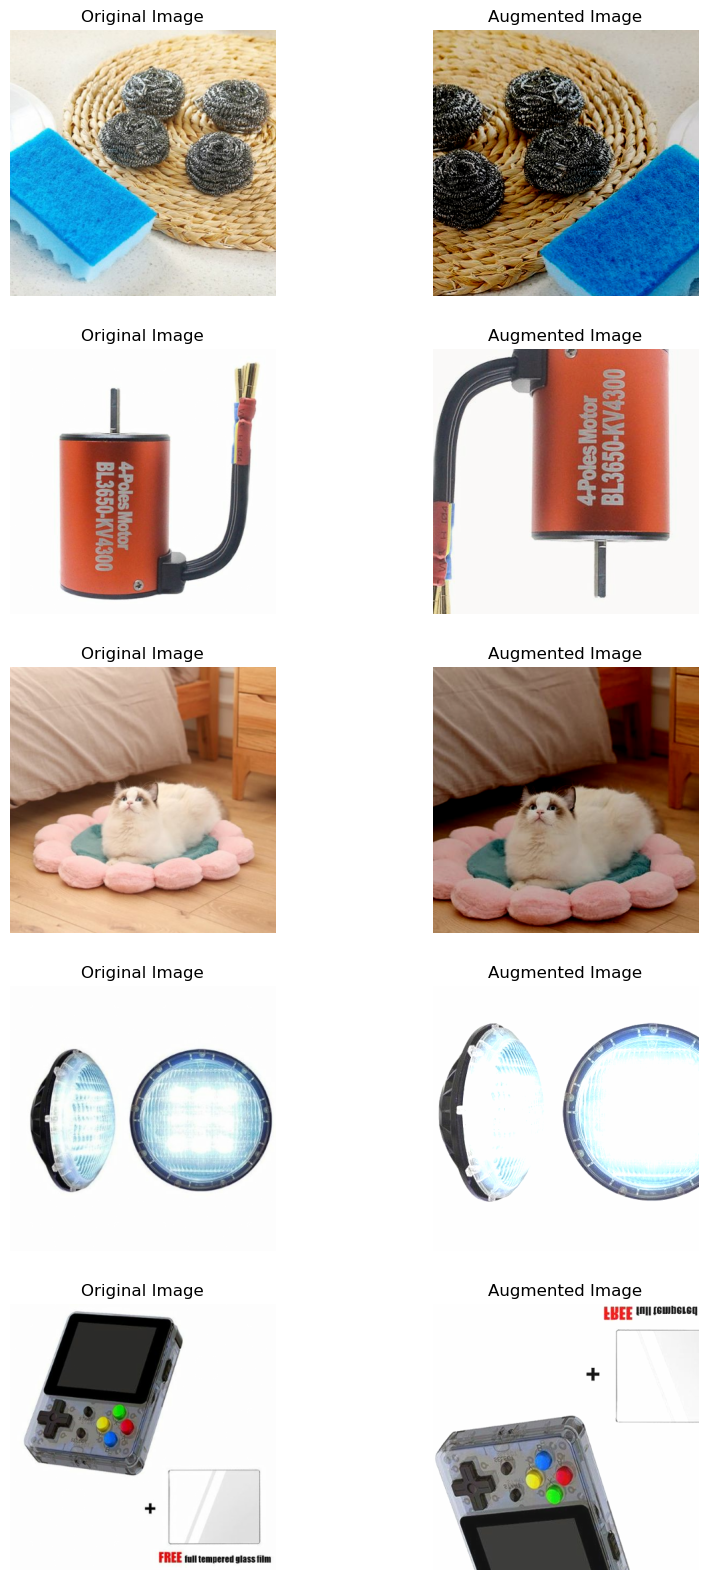

In [23]:
random_samples = X_train_path[:5]

# Créer une figure pour afficher les images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, nom in enumerate(random_samples):
    # Charger l'image originale
    original_image = load_image(nom)/255.0

    # Redimensionner l'image pour l'affichage
    #resized_image = tf.image.resize(original_image, (IMGSIZE, IMGSIZE))

    # Charger l'image à l'aide de la fonction load_image
    augmented_image = load_and_augment_image(nom)/255.0

    # Afficher l'image originale et l'image augmentée
    axs[i, 0].imshow(original_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    axs[i, 1].imshow(augmented_image)
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Augmented Image')

plt.show()

#### Chargement et Configuration du Modèle EfficientNetB1
Configuration de EfficientNetB1 pour l'apprentissage par transfert :  
Une partie du modèle pré-entraîné peut être gelée pour conserver les caractéristiques générales.  
Les couches supérieures sont ajustées pour apprendre des spécificités de la nouvelle tâche de classification d'images.  

Ici toutes les couches sont gelées.


In [24]:
from tensorflow.keras.applications import EfficientNetB1
#  help(tf.keras.applications)
# Chargement du modèle efficientNet
base_model = EfficientNetB1(include_top=False, weights='imagenet',input_shape=(IMGSIZE,IMGSIZE,3))

niv1,niv2 = 0,0
for layer in base_model.layers[:FREEZE_LAYERS]:
    niv1  +=1
    layer.trainable = False
  
# Entrainement des derniers layers de classification
for layer in base_model.layers[FREEZE_LAYERS:]:
    niv2 += 1
    layer.trainable = True
base_model.summary()
print("Nb layers gelées : ",niv1)
print("nb layers dégelées : ", niv2)

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 400, 400, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 400, 400, 3)  0           ['normalization[0][0

#### Construction du Modèle Séquentiel
L'objectif de cette architecture est de tirer parti de l'extraction de caractéristiques avancées d'EfficientNetB1  
et de compléter avec des couches personnalisées qui adaptent ces caractéristiques pour une classification sur 27 classes spécifiques à la tâche.  
1. Régularisation : Les couches de **dropout** et de **batch normalization** aident à réduire le risque de surapprentissage,
    surtout avec un modèle de grande capacité.
3. **GlobalAveragePooling2D** : Les couches denses et le pooling global permettent au modèle de capturer et de combiner
    efficacement des caractéristiques complexes pour une prédiction précise.

In [25]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
model = Sequential()
model.add(base_model) # Ajout du modèle EfficientB1
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(27, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 13, 13, 1280)     6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1

#### Compilation du Modèle
1.  L'optimiseur Adam est utilisé pour ajuster les poids du modèle durant l'entraînement.  
2.  loss='categorical_crossentropy': Cette fonction de perte est utilisée pour les problèmes de classification multi-classes
    où les classes sont mutuellement exclusives.

In [26]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#### Définition des Chemins de Sauvegarde

In [27]:
saveweights = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_weights.h5'
trainacc  = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_train_acc.pkl'
valacc = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_al_acc.pkl'
loss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_loss.pkl'
valloss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_valloss.pkl'
dfpredict = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+ '_df_predict.csv'
testoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_y_test_original2.pkl'
predoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_test_pred_original2.pkl'

#### Lancement de l'entrainement
1. Création  d'un callback pour sauvegarder le modèle au cours de l'entraînement.
2. Création d'un callback qui réduit automatiquement le taux d'apprentissage lorsque la métrique surveillée cesse de s'améliorer.
3. Entraînement du modèle avec les ensembles de données spécifiés et les callbacks configurés.
   

In [28]:
from tensorflow.keras import callbacks
NBETAPE=6
checkpoint = callbacks.ModelCheckpoint(filepath=ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_checkpoint.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='min',
                                       save_freq='epoch')

# Réduction automatique du taux d'apprentissage

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')



training_history = model.fit(dataset_train, epochs=40, validation_data = dataset_test, callbacks=[lr_plateau])



Epoch 1/40
2335/2335 [==============================] - 794s 337ms/step - loss: 2.1210 - accuracy: 0.4013 - val_loss: 1.5010 - val_accuracy: 0.5525 - lr: 1.0000e-04
Epoch 2/40
2335/2335 [==============================] - 822s 352ms/step - loss: 1.7663 - accuracy: 0.4825 - val_loss: 1.4169 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 3/40
2335/2335 [==============================] - 832s 356ms/step - loss: 1.6336 - accuracy: 0.5145 - val_loss: 1.3696 - val_accuracy: 0.5900 - lr: 1.0000e-04
Epoch 4/40
2335/2335 [==============================] - 840s 360ms/step - loss: 1.5624 - accuracy: 0.5320 - val_loss: 1.3419 - val_accuracy: 0.5967 - lr: 1.0000e-04
Epoch 5/40
2335/2335 [==============================] - 800s 342ms/step - loss: 1.4927 - accuracy: 0.5505 - val_loss: 1.3124 - val_accuracy: 0.6056 - lr: 1.0000e-04
Epoch 6/40
2335/2335 [==============================] - 800s 343ms/step - loss: 1.4354 - accuracy: 0.5654 - val_loss: 1.2995 - val_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 7/40

#### Sauvegarde des Poids du Modèle, des précisions, des pertes et des prédictions.

In [29]:
print("Sauvegarde des poids du modèle ... ")
model.save_weights(saveweights)
#print(saveweights)
print("-"*20)

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
tloss = training_history.history['loss']
tvalloss=training_history.history['val_loss']

print("Sauvegardes des precisions et les des pertes ... ")
with open(trainacc, 'wb') as f:
    pickle.dump(train_acc, f)
with open(valacc, 'wb') as f:
    pickle.dump(val_acc, f)
with open(loss, 'wb') as f:
    pickle.dump(tloss, f)
with open(valloss, 'wb') as f:
    pickle.dump(tvalloss, f)
#print(trainacc)
#print(valacc)
#print(loss)
#print(valloss)
print("-"*20)
    
y_test_original = np.argmax(y_test_Network, axis=1)
#print(y_test_Network[0])
y_test_original2=label_encoder.inverse_transform(y_test_original)

predictions = model.predict(dataset_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_original2=label_encoder.inverse_transform(y_pred)

#print("-"*20)

top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_original2})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')

df_pred = pd.DataFrame()
for c in Lcat:
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)

print("Sauvegardes des rerultats ... ")
df_pred.to_csv(dfpredict)
with open(testoriginal, 'wb') as f:
    pickle.dump(y_test_original2, f)
with open(predoriginal, 'wb') as f:
    pickle.dump(test_pred_original2, f)
#print(testoriginal)
#print(predoriginal)

Sauvegarde des poids du modèle ... 
--------------------
Sauvegardes des precisions et les des pertes ... 
--------------------
531/531 [==============================] - 130s 243ms/step
Sauvegardes des rerultats ... 


#### Affichage des precisions et des pertes par époque

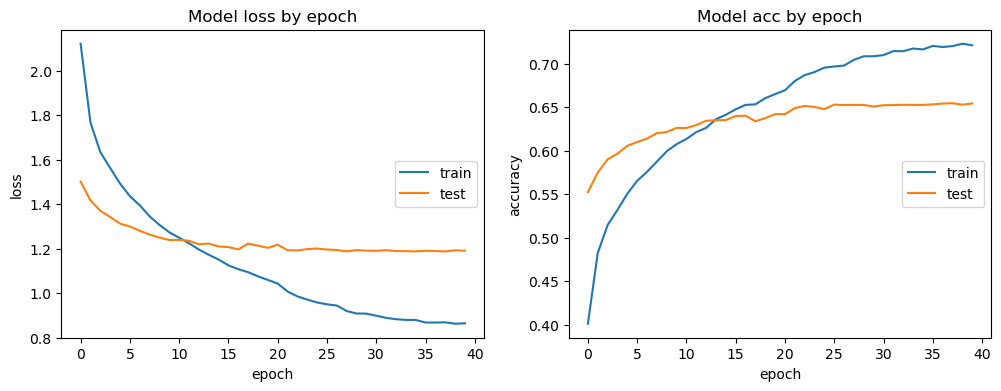

In [30]:



plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

   

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

#### Affichage des 3 meilleurs prédictions par catégorie
classé par ordre d'échantillonage obtenu après over et under sampling

In [31]:

#=========================================================================
dfp=pd.read_csv(dfpredict)
dfs=pd.read_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE) # effectifs par classe retenu après over et under sampling
dfs.rename({'Unnamed: 0':'Categorie'},axis=1,inplace=True)
df_resume=dfs.merge(dfp,on='Categorie',how='inner')
df_resume.drop('Unnamed: 0',axis=1,inplace=True)
df_resume.head(27)

,Categorie,Qunatity,predict,pourc,predict2,pourc2,predict3,pourc3
0,2583,5000,2583,0.856513,2585,0.017140,2522,0.015671
1,1560,4058,1560,0.601970,2060,0.066995,2522,0.047291
2,1300,4036,1300,0.835481,1280,0.032706,2585,0.018831
3,2060,3994,2060,0.497497,1560,0.091091,1920,0.057057
4,2522,3991,2522,0.722445,2583,0.033066,2403,0.028056
5,1280,3896,1280,0.400411,1300,0.188912,1140,0.096509
6,2403,3819,2403,0.647120,2280,0.138220,10,0.056545
7,2280,3808,2280,0.739496,2403,0.067227,10,0.065126
8,1920,3442,1920,0.837398,1560,0.041812,2060,0.029036
9,1160,3162,1160,0.922882,2280,0.017699,2462,0.012642


#### Génération et Affichage de la Matrice de Confusion
1. La **matrice de confusion** fournit une représentation visuelle des performances du modèle, montrant non seulement les bonnes classifications  
mais aussi les erreurs (**faux positifs** et **faux négatifs**).  
2. En identifiant où le modèle a échoué (c.-à-d., les cellules non-diagonales de la matrice), on peut cibler les améliorations à apporter  
au modèle ou aux données d'entraînement.  
3. Analyser la matrice de confusion permet d'identifier des classes spécifiques qui sont souvent confondues, ce qui peut indiquer un besoin d'ajustement des caractéristiques d'entrée ou d'ajout de données supplémentaires pour ces classes.


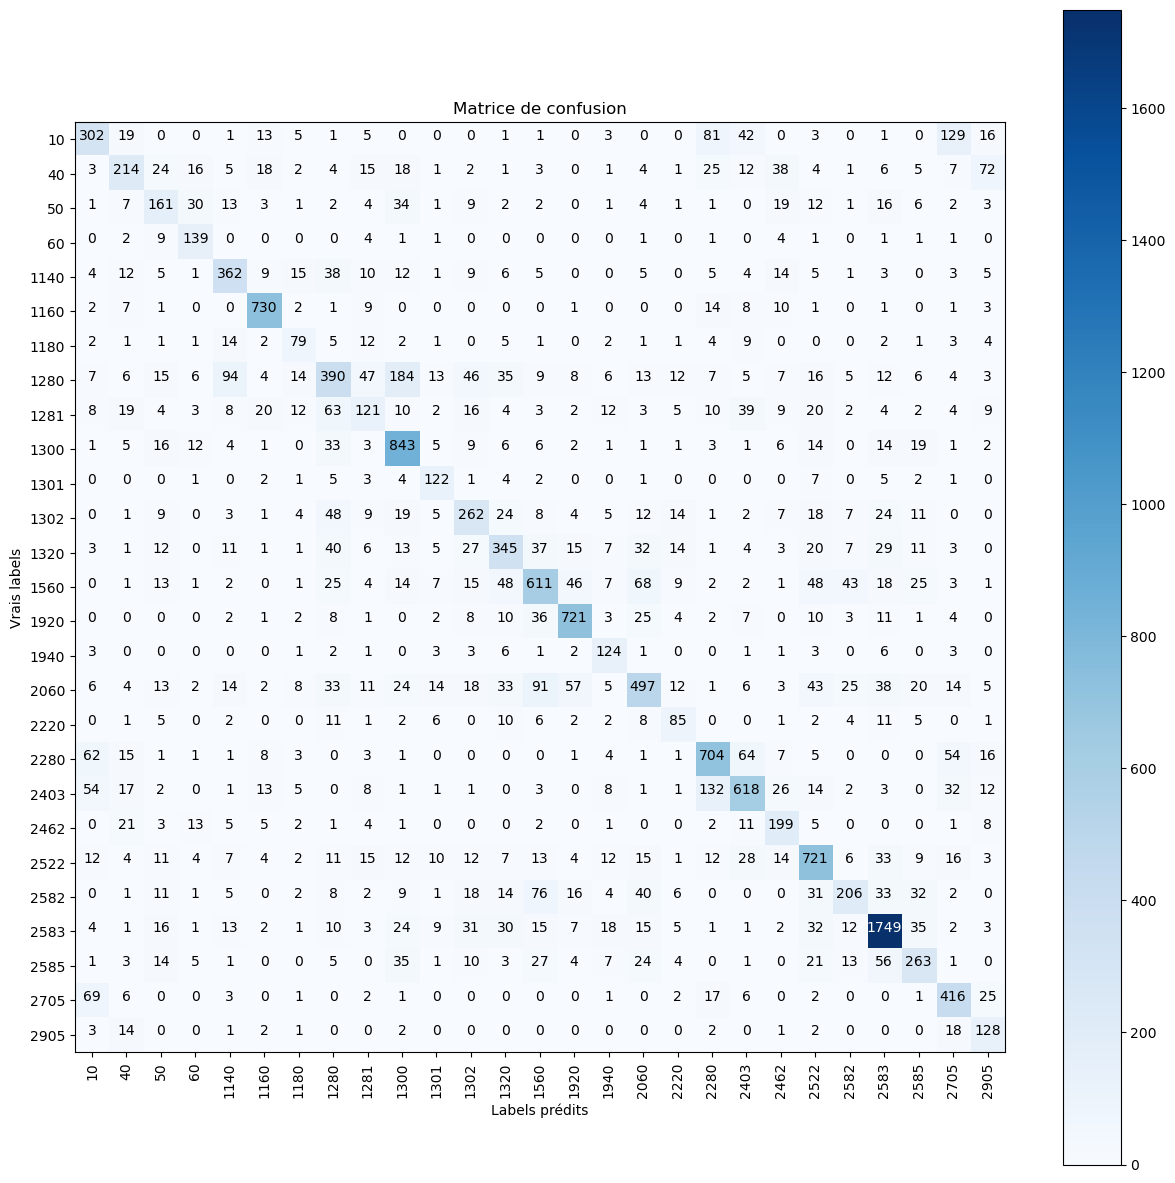

In [32]:
import itertools # Pour créer des itérateurs
#cnf_matrix = confusion_matrix(y_test, test_pred_orinal,labels=[10,2280,2403,2705,40,50,2462,1280,1281])
cnf_matrix = confusion_matrix(y_test, test_pred_original2,labels=sorted(list(set(y_test_original2))))
#print(cnf_matrix)


classes=sorted(list(set(y_test_original2)))
b=list(set(y_test_original2))

plt.figure(figsize=(15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()


#### Création du DataFrame et du Tableau Croisé
Le tableau croisé permet de voir la proportion de chaque classe réelle prédite correctement ou incorrectement comme d'autres classes,  
ce qui aide à évaluer la performance du modèle de manière plus granulaire que la simple précision.

In [33]:
top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_original2})
df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,
10,0.484751,0.030498,0.000000,0.000000,0.001605,0.020867,0.008026,0.001605,0.008026,0.000000,...,0.000000,0.130016,0.067416,0.000000,0.004815,0.000000,0.001605,0.000000,0.207063,0.025682
40,0.005976,0.426295,0.047809,0.031873,0.009960,0.035857,0.003984,0.007968,0.029880,0.035857,...,0.001992,0.049801,0.023904,0.075697,0.007968,0.001992,0.011952,0.009960,0.013944,0.143426
50,0.002976,0.020833,0.479167,0.089286,0.038690,0.008929,0.002976,0.005952,0.011905,0.101190,...,0.002976,0.002976,0.000000,0.056548,0.035714,0.002976,0.047619,0.017857,0.005952,0.008929
60,0.000000,0.012048,0.054217,0.837349,0.000000,0.000000,0.000000,0.000000,0.024096,0.006024,...,0.000000,0.006024,0.000000,0.024096,0.006024,0.000000,0.006024,0.006024,0.006024,0.000000
1140,0.007491,0.022472,0.009363,0.001873,0.677903,0.016854,0.028090,0.071161,0.018727,0.022472,...,0.000000,0.009363,0.007491,0.026217,0.009363,0.001873,0.005618,0.000000,0.005618,0.009363
1160,0.002528,0.008850,0.001264,0.000000,0.000000,0.922882,0.002528,0.001264,0.011378,0.000000,...,0.000000,0.017699,0.010114,0.012642,0.001264,0.000000,0.001264,0.000000,0.001264,0.003793
1180,0.013072,0.006536,0.006536,0.006536,0.091503,0.013072,0.516340,0.032680,0.078431,0.013072,...,0.006536,0.026144,0.058824,0.000000,0.000000,0.000000,0.013072,0.006536,0.019608,0.026144
1280,0.007187,0.006160,0.015400,0.006160,0.096509,0.004107,0.014374,0.400411,0.048255,0.188912,...,0.012320,0.007187,0.005133,0.007187,0.016427,0.005133,0.012320,0.006160,0.004107,0.003080
1281,0.019324,0.045894,0.009662,0.007246,0.019324,0.048309,0.028986,0.152174,0.292271,0.024155,...,0.012077,0.024155,0.094203,0.021739,0.048309,0.004831,0.009662,0.004831,0.009662,0.021739


#### Évaluation des Prédictions
Ce rapport inclut des métriques comme la précision, le rappel (recall), le score F1 et le support pour chaque classe individuelle :  

1. Précision (**Precision**) : Le ratio des prédictions correctes pour chaque classe par rapport à toutes les prédictions faites pour cette classe.
2. Rappel (**Recall**) : Le ratio des prédictions correctes pour chaque classe par rapport au nombre total d'instances réelles de cette classe.
3. **Score F1** : La moyenne harmonique de la précision et du rappel, fournissant une mesure unique de la performance qui équilibre les deux.
4. **Support** : Le nombre d'occurrences réelles de chaque classe dans l'ensemble de test.

In [34]:
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original2, test_pred_original2)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original2, test_pred_original2)))

Précision de la prédiction: 65.42628356099858 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.55      0.48      0.52       623
          40       0.56      0.43      0.48       502
          50       0.47      0.48      0.47       336
          60       0.59      0.84      0.69       166
        1140       0.63      0.68      0.65       534
        1160       0.87      0.92      0.89       791
        1180       0.48      0.52      0.50       153
        1280       0.52      0.40      0.45       974
        1281       0.40      0.29      0.34       414
        1300       0.67      0.84      0.74      1009
        1301       0.58      0.76      0.66       161
        1302       0.53      0.53      0.53       498
        1320       0.58      0.53      0.56       648
        1560       0.64      0.60      0.62      1015
        1920       0.81      0.84      0.82       861
        1940       0.53      0.7

#### Résumé de la classification obtenue

In [35]:
df_pred = pd.DataFrame()
for c in Lcat:
    print(c, '   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    for index, value in s.items():  # Change ici
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")
df_pred.to_csv('dfpredict')

10    ------    livres
  : 10,  : 48.48 % , livres
  : 2705,  : 20.71 % , bds et livres
  : 2280,  : 13.0 % , magazines
  : 2403,  : 6.74 % , livres et bds
  : 40,  : 3.05 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 42.63 % , jeux video pour pc et consoles
  : 2905,  : 14.34 % , Jeu En téléchargement
  : 2462,  : 7.57 % , consoles de jeux video et jeux videos
  : 2280,  : 4.98 % , magazines
  : 50,  : 4.78 % ,  accesoires jeux video
50    ------     accesoires jeux video
  : 50,  : 47.92 % ,  accesoires jeux video
  : 1300,  : 10.12 % , Petites voitures (jouets) et maquettes
  : 60,  : 8.93 % , consoles de jeux video
  : 2462,  : 5.65 % , consoles de jeux video et jeux videos
  : 2583,  : 4.76 % , accesoires de piscine
60    ------    consoles de jeux video
  : 60,  : 83.73 % , consoles de jeux video
  : 50,  : 5.42 % ,  accesoires jeux video
  : 1281,  : 2.41 % , jeux de societe/cartes
  : 2462,  : 2.41 % , consoles de jeux video et jeu